# Stacked auto-encoders and fully-connected networks 

A deep regression model and hyperspectral imaging for rapid detection of nitrogen concentration in potato leaf, using Stacked auto-encoders (SAE) and fully-connected networks (FNN)

In [3]:
from __future__ import division, print_function, absolute_import

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [4]:
data = pd.read_csv('data/Process.csv')
data.columns.tolist()

['Biomass',
 'd0(%)',
 'd1(%)',
 'd2(%)',
 'd3(%)',
 'd4(%)',
 'd5(%)',
 'd6(%)',
 'd7(%)',
 'd8(%)',
 'd9(%)',
 'p10',
 'p100',
 'p30',
 'p40',
 'p50',
 'p60',
 'p70',
 'p80',
 'p90',
 'stdev',
 'mean']

In [11]:
headers = ["699nm","713nm","726nm","739nm","752nm","766nm","780nm","794nm","807nm","821nm","834nm","847nm",
           "859nm","872nm","884nm","896nm","908nm","919nm","930nm","941nm","952nm","962nm","972nm","982nm",
           "992nm","total Nitrogen perc"]

len(headers)

26

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# headers = ["699nm","713nm","726nm","739nm","752nm","766nm","780nm","794nm","807nm","821nm","834nm","847nm",
#            "859nm","872nm","884nm","896nm","908nm","919nm","930nm","941nm","952nm","962nm","972nm","982nm",
#            "992nm","total Nitrogen perc"]
headers = ['Biomass',
 'd0(%)',
 'd1(%)',
 'd2(%)',
 'd3(%)',
 'd4(%)',
 'd5(%)',
 'd6(%)',
 'd7(%)',
 'd8(%)',
 'd9(%)',
 'p10',
 'p100',
 'p30',
 'p40',
 'p50',
 'p60',
 'p70',
 'p80',
 'p90',
 'stdev',
 'mean']
# data
data = pd.read_csv('data/Process.csv')
#data = pd.read_csv('../../../data/final_data_table_single_avg.csv') 

data = data[headers] 

data.head()

split = int(data.shape[0]*0.7)


In [14]:
len(headers)

22

In [13]:
data.head()

,Biomass,d0(%),d1(%),d2(%),d3(%),d4(%),d5(%),d6(%),d7(%),d8(%),...,p100,p30,p40,p50,p60,p70,p80,p90,stdev,mean
0,12.3566,8.19879,9.232470,7.330600,9.007360,13.727701,14.745000,16.089800,14.7719,6.87199,...,23.664400,9.211230,12.049300,13.972700,15.5039,16.783199,18.096800,19.659000,5.65614,12.913300
1,12.2161,5.76144,5.305050,3.715490,9.066910,19.011000,20.730500,20.040500,12.3532,3.99627,...,28.674801,14.574300,16.232000,17.695000,19.0669,20.660400,22.071501,23.840700,6.03931,16.888700
2,17.4936,3.62239,2.228110,4.682050,9.753370,22.247300,29.236999,13.321100,10.6097,4.26904,...,31.674500,16.793800,18.187799,19.341700,20.7523,21.974899,23.261101,24.955900,5.69790,18.747900
3,16.5764,2.27345,0.627018,0.822914,2.214520,7.660460,21.845700,36.690500,23.2660,4.57423,...,25.309700,16.758301,17.784500,18.559200,19.3626,20.236500,21.020000,21.879200,3.72430,17.886801
4,17.7037,0.00000,0.000000,0.208468,0.958235,10.335300,29.522699,38.866201,16.0621,4.11096,...,28.601299,18.677099,19.494699,20.155001,20.7869,21.839399,22.816000,24.125401,3.19634,20.146500


In [8]:
split

119

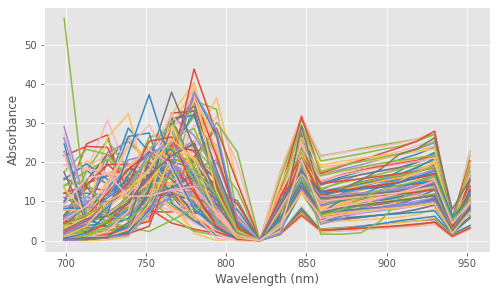

In [17]:
# Y_calib = pd.DataFrame.as_matrix(data.iloc[:split, 0])
# Y_valid = pd.DataFrame.as_matrix(data.iloc[split:, 0])

# # Get spectra
# X_calib = pd.DataFrame.as_matrix(data.iloc[:split, 1:22])
# X_valid = pd.DataFrame.as_matrix(data.iloc[split:, 1:22])

Y_calib = data.iloc[:split, 0].values
Y_valid = data.iloc[split:, 0].values

# Get spectra
X_calib = data.iloc[:split, 1:22].values
X_valid = data.iloc[split:, 1:22].values
# Get wavelengths 
wl = [699,713,726,739,752,766,780,794,807,821,834,847,859,872,884,896,908,919,930,941,952]
    
# Plot spectra
plt.figure(figsize=(8,4.5))
with plt.style.context(('ggplot')):
    plt.plot(wl, X_calib.T)
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Absorbance')    
plt.show()

In [18]:
print(X_valid.shape, Y_valid.shape )


(52, 21) (52,)


In [34]:
data.shape[0]

171

In [83]:

# Training Parameters
learning_rate = 0.001
num_steps = 500
batch_size = 8 #256

display_step = 10
examples_to_show = 10

# Network Parameters
num_hidden_1 = 256 # 1st layer num features
num_hidden_2 = 256 # 2nd layer num features (the latent dim)
num_input = 21 #784 # MNIST data input (img shape: 28*28)
num_output = 1

# tf Graph input (only pictures)
X = tf.placeholder("float", [None, num_input])
y_true = tf.placeholder("float", [None, num_output])

weights = {
    'encoder_h1': tf.Variable(tf.random_normal([num_input, num_hidden_1])),
    'encoder_h2': tf.Variable(tf.random_normal([num_hidden_1, num_hidden_2])),
    'decoder_h1': tf.Variable(tf.random_normal([num_hidden_2, num_hidden_1])),
    'decoder_h2': tf.Variable(tf.random_normal([num_hidden_1, num_output])),
}
biases = {
    'encoder_b1': tf.Variable(tf.random_normal([num_hidden_1])),
    'encoder_b2': tf.Variable(tf.random_normal([num_hidden_2])),
    'decoder_b1': tf.Variable(tf.random_normal([num_hidden_1])),
    'decoder_b2': tf.Variable(tf.random_normal([num_output])),
}


In [84]:
# Building the encoder
def encoder(x):
    # Encoder Hidden layer with sigmoid activation #1
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['encoder_h1']),
                                   biases['encoder_b1']))
    # Encoder Hidden layer with sigmoid activation #2
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['encoder_h2']),
                                   biases['encoder_b2']))
    return layer_2


# Building the decoder
# def decoder(x):
#     # Decoder Hidden layer with sigmoid activation #1
#     layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['decoder_h1']),
#                                    biases['decoder_b1']))
#     # Decoder Hidden layer with sigmoid activation #2
#     layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['decoder_h2']),
#                                    biases['decoder_b2']))
#     return layer_2

# Neural net
# def nn(x):
#     # Decoder Hidden layer with sigmoid activation #1
#     layer_1 = tf.nn.relu(tf.add(tf.matmul(x, weights['decoder_h1']),
#                                    biases['decoder_b1']))
#     # Decoder Hidden layer with sigmoid activation #2
#     layer_2 = tf.nn.relu(tf.add(tf.matmul(layer_1, weights['decoder_h2']),
#                                    biases['decoder_b2']))
#     return layer_2

def nn(x):
    # neural network layers
    l1 = tf.layers.dense(x, 80, tf.nn.relu)          # hidden layer
    output = tf.layers.dense(l1, num_output) 
    return output

# Construct model
encoder_op = encoder(X)
#decoder_op = decoder(encoder_op)
decoder_op = nn(encoder_op)

# Prediction
y_pred = decoder_op

# Define loss and optimizer, minimize the squared error
loss = tf.reduce_mean(tf.pow(y_true - y_pred, 2))
optimizer = tf.train.RMSPropOptimizer(learning_rate).minimize(loss)

# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

In [85]:
def next_batch(num, data, labels):
    '''
    Return a total of `num` random samples and labels. 
    '''
    idx = np.arange(0 , len(data))
    np.random.shuffle(idx)
    idx = idx[:num]
    data_shuffle = [data[i] for i in idx]
    labels_shuffle = [labels[i] for i in idx]

    return np.asarray(data_shuffle), np.asarray(labels_shuffle).reshape(len(labels_shuffle),1)


In [86]:
# Start Training
# Start a new TF session
sess = tf.Session()

# Run the initializer
sess.run(init)

# Training
batch_x, batch_y = [], []
for i in range(1, num_steps+1):
    # Prepare Data
    # Get the next batch of MNIST data (only images are needed, not labels)
    batch_x, batch_y = next_batch(batch_size, X_calib, Y_calib)
    
    # Run optimization op (backprop) and cost op (to get loss value)
    _, l = sess.run([optimizer, loss], feed_dict={X: batch_x, y_true: batch_y})
    # Display logs per step
    if i % display_step == 0 or i == 1:
        print('Step %i: Minibatch Loss: %f' % (i, l))
    

Step 1: Minibatch Loss: 93.467056
Step 10: Minibatch Loss: 75.106148
Step 20: Minibatch Loss: 40.197987
Step 30: Minibatch Loss: 26.082329
Step 40: Minibatch Loss: 24.297794
Step 50: Minibatch Loss: 7.769341
Step 60: Minibatch Loss: 8.071838
Step 70: Minibatch Loss: 26.799534
Step 80: Minibatch Loss: 8.310064
Step 90: Minibatch Loss: 8.659592
Step 100: Minibatch Loss: 3.140508
Step 110: Minibatch Loss: 10.358101
Step 120: Minibatch Loss: 3.531183
Step 130: Minibatch Loss: 4.800712
Step 140: Minibatch Loss: 1.547650
Step 150: Minibatch Loss: 1.569980
Step 160: Minibatch Loss: 1.004597
Step 170: Minibatch Loss: 0.659448
Step 180: Minibatch Loss: 2.686080
Step 190: Minibatch Loss: 0.947046
Step 200: Minibatch Loss: 0.300334
Step 210: Minibatch Loss: 1.694227
Step 220: Minibatch Loss: 1.634171
Step 230: Minibatch Loss: 1.014410
Step 240: Minibatch Loss: 1.651768
Step 250: Minibatch Loss: 2.044161
Step 260: Minibatch Loss: 0.656609
Step 270: Minibatch Loss: 2.227413
Step 280: Minibatch Loss

In [88]:
# Testing
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from math import sqrt

# Encode and decode images from test set and visualize their reconstruction.
print("#test data: ", len(Y_valid))
#n = 10
#for i in range(n):
# MNIST test set
batch_x, batch_y = next_batch(len(Y_valid), X_valid, Y_valid)
#batch_x, batch_y = X_valid, np.asarray(Y_valid).reshape(len(Y_valid),1)
# Encode and decode the digit image
y_pred = sess.run(decoder_op, feed_dict={X: batch_x, y_true: batch_y})
# print("mean_squared_error:", mean_squared_error(batch_y,y_pred))  
RMES = mean_squared_error(batch_y,y_pred)
MAE = mean_absolute_error(batch_y,y_pred)
R2 = r2_score(batch_y,y_pred)

# 预测结果存为文件测试
# pd.DataFrame(Y_pred).to_csv('pred.csv', index=False)
print('Done.\nR-squared: %f\nRMSE: %f\nMAE: %f' % (R2, RMES, MAE))
#    for j in range(n):
#       print(pow(batch_y - y_pred, 2))  
        

# print("Reconstructed Images")
# plt.figure(figsize=(n, n))
# plt.imshow(canvas_recon, origin="upper", cmap="gray")
# plt.show()

#test data:  52
Done.
R-squared: 0.658973
RMSE: 6.058374
MAE: 2.031880
